## Skeleton Code

The code below provides a skeleton for the model building & training component of your project. You can add/remove/build on code however you see fit, this is meant as a starting point.

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt

##Import any other stats/DL/ML packages you may need here. E.g. Keras, scikit-learn, etc.
from itertools import chain
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from random import sample

Using TensorFlow backend.


## Do some early processing of your metadata for easier model training:

In [3]:
## Below is some helper code to read all of your full image filepaths into a dataframe for easier manipulation
## Load the NIH data to all_xray_df
all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('/data','images*', '*', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])
all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)
all_xray_df.sample(3)

Scans found: 112120 , Total Headers 112120


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
7566,00001986_009.png,Nodule,9,1986,59,F,AP,2500,2048,0.168,0.168,NaN,/data/images_002/images/00001986_009.png
72807,00017944_012.png,Cardiomegaly|Effusion|Pleural_Thickening,12,17944,35,M,PA,2992,2991,0.143,0.143,NaN,/data/images_008/images/00017944_012.png
41214,00010677_019.png,Infiltration,19,10677,55,F,AP,2500,2048,0.168,0.168,NaN,/data/images_005/images/00010677_019.png


In [4]:
## Here you may want to create some extra columns in your table with binary indicators of certain diseases 
## rather than working directly with the 'Finding Labels' column

all_labels = np.unique(list(chain(*all_xray_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x)>0]

for c_label in all_labels:
    if len(c_label)>1: # leave out empty labels
        all_xray_df[c_label] = all_xray_df['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)
all_labels

['Atelectasis',
 'Cardiomegaly',
 'Consolidation',
 'Edema',
 'Effusion',
 'Emphysema',
 'Fibrosis',
 'Hernia',
 'Infiltration',
 'Mass',
 'No Finding',
 'Nodule',
 'Pleural_Thickening',
 'Pneumonia',
 'Pneumothorax']

In [5]:
## Here we can create a new column called 'pneumonia_class' that will allow us to look at 
## images with or without pneumonia for binary classification

all_xray_df['pneumonia_class'] = all_xray_df.apply(lambda row: '1' if row.Pneumonia==1.0 else '0', axis=1)

In [6]:
all_xray_df[['path', 'pneumonia_class']]

,path,pneumonia_class
0,/data/images_001/images/00000001_000.png,0
1,/data/images_001/images/00000001_001.png,0
2,/data/images_001/images/00000001_002.png,0
3,/data/images_001/images/00000002_000.png,0
4,/data/images_001/images/00000003_000.png,0
...,...,...
112115,/data/images_012/images/00030801_001.png,1
112116,/data/images_012/images/00030802_000.png,0
112117,/data/images_012/images/00030803_000.png,0
112118,/data/images_012/images/00030804_000.png,0


In [7]:
all_xray_df.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,pneumonia_class
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


## Create your training and testing data:

In [8]:
def create_splits(data):
    
    ## Either build your own or use a built-in library to split your original dataframe into two sets 
    ## that can be used for training and testing your model
    ## It's important to consider here how balanced or imbalanced you want each of those sets to be
    ## for the presence of pneumonia
    
    train_data, valid_data = train_test_split(data, 
                                   test_size = 0.2, 
                                   stratify = all_xray_df['pneumonia_class'])
    
    return train_data, valid_data

train_df, valid_df = create_splits(all_xray_df)

In [9]:
p_inds = train_df[train_df.Pneumonia==1].index.tolist()
np_inds = train_df[train_df.Pneumonia==0].index.tolist()

np_sample = sample(np_inds, len(p_inds))
train_df = train_df.loc[p_inds+np_sample]

In [10]:
train_df['Pneumonia'].sum()/len(train_df)

0.5

In [11]:
# Increase the ratio of pneumonia/non-pneumonia to about 1:3
p_inds2 = valid_df[valid_df.Pneumonia==1].index.tolist()
np_inds2 = valid_df[valid_df.Pneumonia==0].index.tolist()

np_sample2 = sample(np_inds2, len(p_inds2)*3)
valid_df = valid_df.loc[p_inds2+np_sample2]

In [12]:
valid_df['Pneumonia'].sum()/len(valid_df)

0.25

# Now we can begin our model-building & training

#### First suggestion: perform some image augmentation on your data

In [13]:
def my_image_augmentation():
    
    ## recommendation here to implement a package like Keras' ImageDataGenerator
    ## with some of the built-in augmentations 
    
    ## keep an eye out for types of augmentation that are or are not appropriate for medical imaging data
    ## Also keep in mind what sort of augmentation is or is not appropriate for testing vs validation data
    
    ## STAND-OUT SUGGESTION: implement some of your own custom augmentation that's *not*
    ## built into something like a Keras package
    
    my_idg = ImageDataGenerator(
                    rescale=1. / 255.0,
                    samplewise_center=True, 
                    samplewise_std_normalization=True, 
                    horizontal_flip = True,
                    vertical_flip = False, 
                    height_shift_range= 0.05,
                    width_shift_range=0.1, 
                    rotation_range=10, 
                    shear_range = 0.1,
                    zoom_range=0.05
                    )
    
    return my_idg


def make_train_gen(my_train_idg, train_df, img_size):
    
    ## Create the actual generators using the output of my_image_augmentation for your training data
    ## Suggestion here to use the flow_from_dataframe library, e.g.:
    
    train_gen = my_train_idg.flow_from_dataframe(dataframe=train_df, 
                                         directory=None, 
                                         x_col = 'path',
                                         y_col = 'pneumonia_class',
                                         class_mode = 'binary',
                                         target_size = img_size, 
                                         batch_size = 64
                                         )
    
    return train_gen


def make_val_gen(my_val_idg,val_data, img_size):
    
    val_gen = my_val_idg.flow_from_dataframe(dataframe = val_data, 
                                             directory=None, 
                                             x_col = 'path',
                                             y_col = 'pneumonia_class',
                                             class_mode = 'binary',
                                             target_size = img_size, 
                                             batch_size = 64) 
    
    return val_gen

In [14]:
train_img_gen = my_image_augmentation()
train_gen = make_train_gen(train_img_gen,train_df, (224,224))

Found 2290 validated image filenames belonging to 2 classes.


In [15]:
val_img_gen = ImageDataGenerator(rescale=1./255.0)
val_gen = make_val_gen(val_img_gen,valid_df, (224,224))

Found 1144 validated image filenames belonging to 2 classes.


In [16]:
## May want to pull a single large batch of random validation data for testing after each epoch:
valX, valY = val_gen.next()

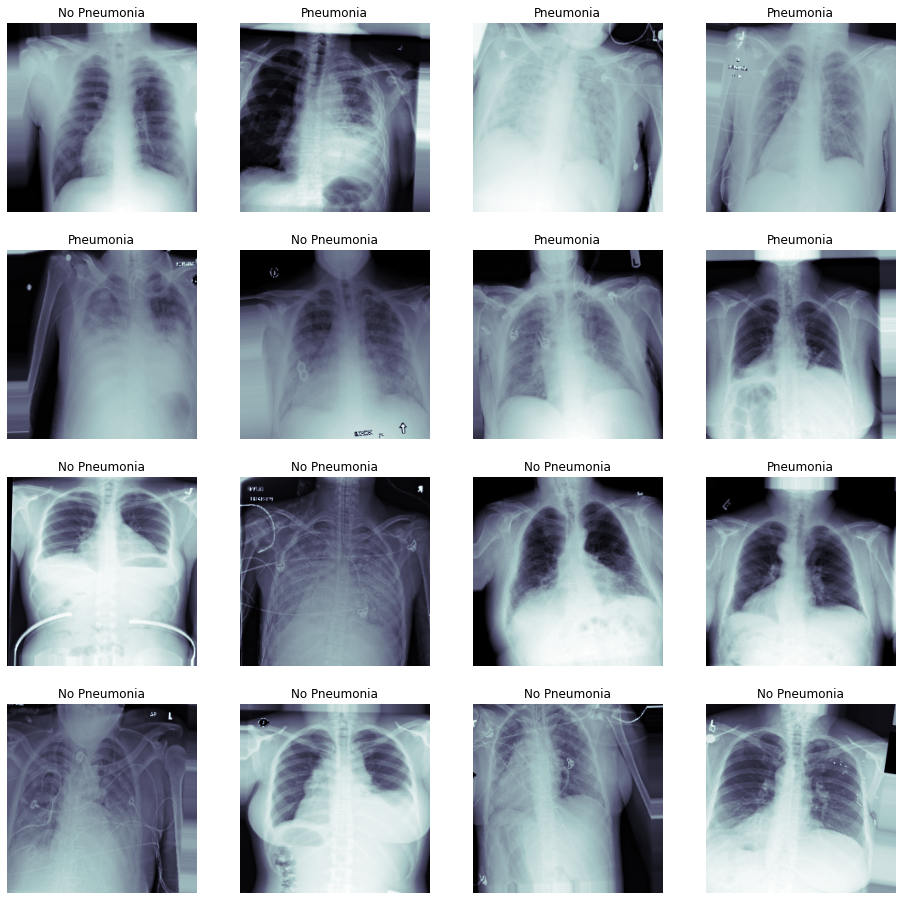

In [17]:
## May want to look at some examples of our augmented training data. 
## This is helpful for understanding the extent to which data is being manipulated prior to training, 
## and can be compared with how the raw data look prior to augmentation

t_x, t_y = next(train_gen)
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        c_ax.set_title('Pneumonia')
    else:
        c_ax.set_title('No Pneumonia')
    c_ax.axis('off')

## Build your model: 

Recommendation here to use a pre-trained network downloaded from Keras for fine-tuning

In [36]:
from keras.layers import GlobalAveragePooling2D, Reshape, AveragePooling2D,MaxPooling2D, MaxPool2D, Dense, Dropout, Flatten, Input, Conv2D, multiply, LocallyConnected2D, Lambda, AvgPool2D
from keras.models import Model
from keras.layers import BatchNormalization
from keras.applications.vgg16 import VGG16
from tqdm import tqdm
from keras.models import Sequential
from keras.optimizers import Adam, RMSprop
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
from keras.applications.resnet_v2 import ResNet50V2
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score

In [19]:
def load_pretrained_model():
    
#     model = VGG16(include_top = True, weights = 'imagenet')
#     transfer_layer = model.get_layer('block5_pool')
#     vgg_model = Model(inputs = model.input, outputs = transfer_layer.output)
#     for layer in vgg_model.layers[0:17]:
#         layer.trainable = False
    model = ResNet50V2(include_top=False, weights='imagenet')
    resnet_model =  Model(inputs=model.input, outputs=model.output, name='Resnet')
    resnet_model.trainable = False
    
    return resnet_model



In [20]:
def build_my_model():
    resnet_model = load_pretrained_model()
    my_model = Sequential([resnet_model,
                        BatchNormalization(),
                        Conv2D(1024, 1, activation='relu'),
                        Dropout(0.5),
                        BatchNormalization(),
                        Conv2D(256, 1, activation='relu'),
                        Dropout(0.5),                        
                        AveragePooling2D((7,7)),
                        BatchNormalization(),
                        Conv2D(1, 1, activation='sigmoid'),
                        Reshape((-1,))
                       ])
    optimizer = RMSprop(learning_rate=1e-4)
    loss = 'binary_crossentropy'
    metrics = ['binary_accuracy', 'binary_crossentropy']
    my_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    return my_model

my_model = build_my_model()

In [21]:
my_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Resnet (Model)               (None, None, None, 2048)  23564800  
_________________________________________________________________
batch_normalization_1 (Batch (None, None, None, 2048)  8192      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, None, None, 1024)  2098176   
_________________________________________________________________
dropout_1 (Dropout)          (None, None, None, 1024)  0         
_________________________________________________________________
batch_normalization_2 (Batch (None, None, None, 1024)  4096      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, None, None, 256)   262400    
_________________________________________________________________
dropout_2 (Dropout)          (None, None, None, 256)  

In [22]:
# def build_my_model():
#     vgg_model = load_pretrained_model()
#     # Build new model
#     new_model = Sequential()

#     # Add the convolutional part of the VGG16 model from above
#     new_model.add(vgg_model)

#     # Flatten the output of the VGG16 model because it is from a convolutional layer
#     new_model.add(Flatten())

#     # Add a dense layer. This is for combining features that the VGG16 model has recognized in the image.
#     new_model.add(Dense(1024, activation='relu'))
#     new_model.add(Dropout(0.5))
#     new_model.add(Dense(512, activation='relu'))
#     new_model.add(Dropout(0.3))
#     new_model.add(Dense(128, activation='relu'))
#     new_model.add(Dropout(0.3))
#     new_model.add(Dense(1, activation='sigmoid'))

#     # Set optimizer, loss function and learning rate
#     optimizer = Adam(lr=1e-4)
#     loss = 'binary_crossentropy'
#     metrics = ['binary_accuracy']

#     new_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
#     return new_model

# my_model = build_my_model()

In [23]:
# def build_my_model():
    
#     # my_model = Sequential()
#     # ....add your pre-trained model, and then whatever additional layers you think you might
#     # want for fine-tuning (Flatteen, Dense, Dropout, etc.)
    
#     # if you want to compile your model within this function, consider which layers of your pre-trained model, 
#     # you want to freeze before you compile 
    
#     # also make sure you set your optimizer, loss function, and metrics to monitor
    
#     vgg_model = load_pretrained_model()
    
#     pt_features = Input(vgg_model.get_output_shape_at(0)[1:], name = 'feature_input')
#     pt_depth = vgg_model.get_output_shape_at(0)[-1]
#     bn_features = BatchNormalization(name='Features_BN')(pt_features)
    
#     attn_layer = Conv2D(128, kernel_size = (1,1), padding = 'same', activation = 'elu')(bn_features)
#     attn_layer = Conv2D(32, kernel_size = (1,1), padding = 'same', activation = 'elu')(attn_layer)
#     attn_layer = Conv2D(16, kernel_size = (1,1), padding = 'same', activation = 'elu')(attn_layer)
#     attn_layer = AvgPool2D((2,2), strides = (1,1), padding = 'same')(attn_layer) # smooth results
#     attn_layer = Conv2D(1, kernel_size = (1,1), padding = 'valid', activation = 'sigmoid', name='AttentionMap2D')(attn_layer)

#     up_c2_w = np.ones((1, 1, 1, pt_depth))
#     up_c2 = Conv2D(pt_depth, kernel_size = (1,1), padding = 'same', name='UpscaleAttention',
#                    activation = 'linear', use_bias = False, weights = [up_c2_w])
#     up_c2.trainable = False
#     attn_layer = up_c2(attn_layer)

#     mask_features = multiply([attn_layer, bn_features])
#     gap_features = GlobalAveragePooling2D()(mask_features)
#     gap_mask = GlobalAveragePooling2D()(attn_layer)
#     # to account for missing values from the attention model
#     gap = Lambda(lambda x: x[0]/x[1], name = 'RescaleGAP')([gap_features, gap_mask])


#     gap_dr = Dropout(0.5)(gap)
#     dr_steps = Dropout(0.5)(Dense(128, activation = 'elu')(gap_dr))
#     out_layer = Dense(1, activation = 'sigmoid')(dr_steps)

#     my_model = Model(inputs = [pt_features], outputs = [out_layer], name = 'attention_model')

#     my_model.compile(optimizer = 'adam', loss = 'binary_crossentropy',
#                                metrics = ['binary_accuracy'])
    
    
#     tb_model = Sequential(name = 'combined_model')
#     vgg_model.trainable = False
#     tb_model.add(vgg_model)
#     tb_model.add(my_model)
#     tb_model.compile(optimizer = Adam(lr = 1e-5), loss = 'binary_crossentropy',
#                                metrics = ['binary_accuracy'])
    
#     return tb_model

# my_model = build_my_model()

# ## STAND-OUT Suggestion: choose another output layer besides just the last classification layer of your modele
# ## to output class activation maps to aid in clinical interpretation of your model's results

In [24]:
## Below is some helper code that will allow you to add checkpoints to your model,
## This will save the 'best' version of your model by comparing it to previous epochs of training

## Note that you need to choose which metric to monitor for your model's 'best' performance if using this code. 
## The 'patience' parameter is set to 10, meaning that your model will train for ten epochs without seeing
## improvement before quitting

weight_path="{}_my_model.best.hdf5".format('xray_class')

checkpoint = ModelCheckpoint(weight_path, 
                             monitor= 'val_binary_accuracy', 
                             verbose=1, 
                             save_best_only=True, 
                             mode= 'max', 
                             save_weights_only = True)

early = EarlyStopping(monitor= 'val_binary_accuracy', 
                      mode= 'max', 
                      patience=3)

callbacks_list = [checkpoint, early]

### Start training! 

In [25]:
# train_gen.batch_size = 64
# history = my_model.fit_generator(train_gen, 
#                       validation_data = (valX, valY), 
#                        steps_per_epoch=train_gen.n//train_gen.batch_size,
#                       epochs = 10, 
#                       callbacks = callbacks_list)
history = my_model.fit_generator(train_gen, 
                          validation_data = (valX, valY),
                          epochs = 10, 
                          callbacks = callbacks_list)

Epoch 1/10
36/36 [==============================] - 67s 2s/step - loss: 0.8011 - binary_accuracy: 0.5638 - binary_crossentropy: 0.8018 - val_loss: 0.5003 - val_binary_accuracy: 0.7969 - val_binary_crossentropy: 0.5003

Epoch 00001: val_binary_accuracy improved from -inf to 0.79688, saving model to xray_class_my_model.best.hdf5
Epoch 2/10
36/36 [==============================] - 59s 2s/step - loss: 0.7820 - binary_accuracy: 0.5873 - binary_crossentropy: 0.7827 - val_loss: 0.5321 - val_binary_accuracy: 0.8125 - val_binary_crossentropy: 0.5321

Epoch 00002: val_binary_accuracy improved from 0.79688 to 0.81250, saving model to xray_class_my_model.best.hdf5
Epoch 3/10
36/36 [==============================] - 61s 2s/step - loss: 0.7509 - binary_accuracy: 0.5956 - binary_crossentropy: 0.7508 - val_loss: 0.5559 - val_binary_accuracy: 0.8281 - val_binary_crossentropy: 0.5559

Epoch 00003: val_binary_accuracy improved from 0.81250 to 0.82812, saving model to xray_class_my_model.best.hdf5
Epoch 4

In [26]:
weight_path = "xray_class_my_model.best.hdf5"
my_model.load_weights(weight_path)

##### After training for some time, look at the performance of your model by plotting some performance statistics:

Note, these figures will come in handy for your FDA documentation later in the project

In [27]:
## After training, make some predictions to assess your model's overall performance
## Note that detecting pneumonia is hard even for trained expert radiologists, 
## so there is no need to make the model perfect.
pred_Y = my_model.predict(valX, batch_size = 32, verbose = True)

64/64 [==============================] - 4s 56ms/step


In [28]:

def plot_auc(t_y, p_y):
    
    ## Hint: can use scikit-learn's built in functions here like roc_curve
    
    # Todo
    fpr, tpr, threshold = roc_curve(valY, pred_Y)
    roc_auc = auc(fpr, tpr)
    
    plt.title('Plot AUC')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    return

## what other performance statistics do you want to include here besides AUC? 


def plot_pr(valY, pred_Y):
    fig, c_ax = plt.subplots(1, 1, figsize=(9,9))
    precision, recall, thresholds = precision_recall_curve(valY, pred_Y)
    c_ax.plot(precision, recall, label='%s (AP Score:%0.2f)' % ('Pneumonia', average_precision_score(valY, pred_Y)))
    c_ax.legend()
    c_ax.set_xlabel('Recall')
    c_ax.set_ylabel('Precision')
    return

    
#Also consider plotting the history of your model training:

def plot_history(history):
    plt.figure(figsize=(12, 4))
    legends = ['Training', 'Validation']
    
    plt.subplot(1,2,1)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(legends, loc='upper left')
    
    plt.subplot(1,2,2)
    plt.plot(history.history['binary_accuracy'])
    plt.plot(history.history['val_binary_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(legends, loc='upper left')
    
    plt.tight_layout()
    return

In [29]:
valY

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1.,
       1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.], dtype=float32)

In [30]:
pred_Y

array([[0.2691062 ],
       [0.36956733],
       [0.4377344 ],
       [0.3660944 ],
       [0.45259404],
       [0.43768018],
       [0.40195084],
       [0.37166974],
       [0.5839601 ],
       [0.39393434],
       [0.30131865],
       [0.40601748],
       [0.44304535],
       [0.55515045],
       [0.41079098],
       [0.38356388],
       [0.3109404 ],
       [0.28827357],
       [0.43226022],
       [0.44010988],
       [0.412662  ],
       [0.23651999],
       [0.4314269 ],
       [0.41061568],
       [0.2952135 ],
       [0.28039694],
       [0.3533504 ],
       [0.48281837],
       [0.43595806],
       [0.25267777],
       [0.4566178 ],
       [0.29460377],
       [0.35379684],
       [0.26857272],
       [0.47293952],
       [0.38352937],
       [0.4018575 ],
       [0.37348092],
       [0.3681693 ],
       [0.6049342 ],
       [0.3822668 ],
       [0.25938925],
       [0.3258676 ],
       [0.35965326],
       [0.35126936],
       [0.48136273],
       [0.57035816],
       [0.543

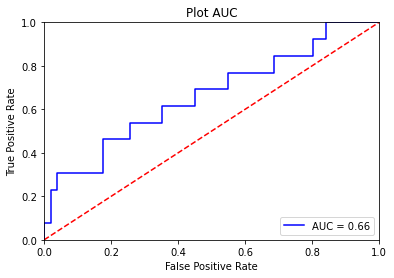

In [31]:
## plot figures
plot_auc(valY, pred_Y)

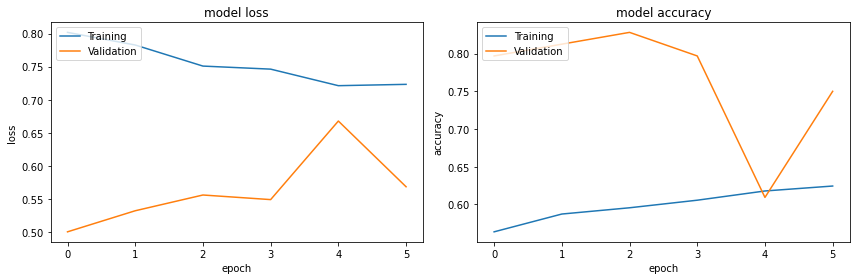

In [32]:
plot_history(history)

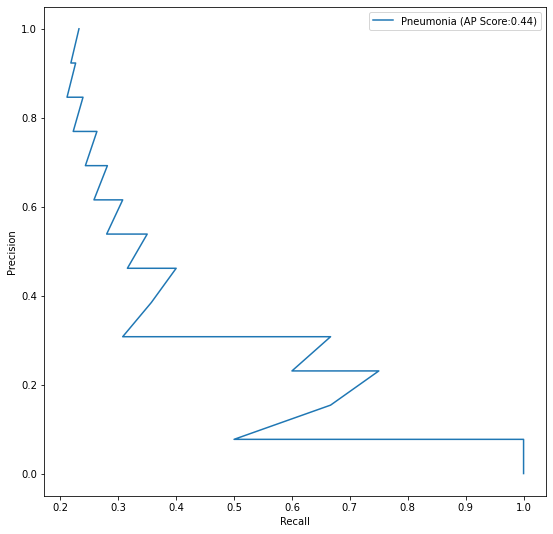

In [37]:
plot_pr(valY, pred_Y)

Once you feel you are done training, you'll need to decide the proper classification threshold that optimizes your model's performance for a given metric (e.g. accuracy, F1, precision, etc.  You decide) 

No handles with labels found to put in legend.


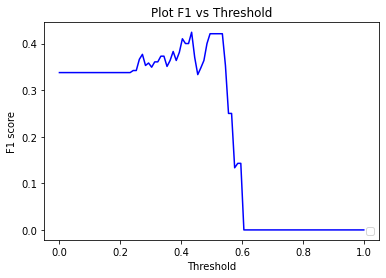

In [59]:
import numpy as np
def plot_f1_thresh():
    x = np.linspace(0,1,100)
    y = []
    for i in x:
        pred_Y_class = pred_Y > i
        score = f1_score(valY, pred_Y_class)
        y.append(score)
    plt.title('Plot F1 vs Threshold')
    plt.plot(x, y, 'b')
    plt.legend(loc = 'lower right')
#     plt.xlim([0, 1])
#     plt.ylim([0, 1])
    plt.xlabel('Threshold')
    plt.ylabel('F1 score')
    plt.show()
    return

plot_f1_thresh()

In [67]:
## Find the threshold that optimize your model's performance,
## and use that threshold to make binary classification. Make sure you take all your metrics into consideration.
from sklearn.metrics import precision_recall_curve, average_precision_score, f1_score
precision, recall, thresholds = precision_recall_curve(valY, pred_Y)

def optimize_accuracy(t_y, p_y):
    best_threshold = None
    best_accuracy = 0.
    for t in np.arange(0.5,1,0.01):
        pred = (p_y.reshape(-1)>t)*1.
        accuracy = np.mean(pred==t_y)
        if accuracy > best_accuracy:
            best_threshold = t
            best_accuracy = accuracy
    return best_threshold, best_accuracy
best_threshold, best_accuracy = optimize_accuracy(valY, pred_Y)
print("Threshold of %.2f gives best accuracy at %.4f"%(best_threshold, best_accuracy))
pred_Y_class = pred_Y > best_threshold
f1_score(valY, pred_Y_class)


Threshold of 0.50 gives best accuracy at 0.8281


0.42105263157894735

In [68]:
def calc_f1(prec, recall):
    return 2*(prec*recall)/(prec+recall)

In [69]:
# Look at the threshod where precision is 0.8
precision_value = 0.8
idx = (np.abs(precision - precision_value)).argmin()
print('Precision is: ' + str(precision[idx]))
print('Recall is: ' + str(recall[idx]))
print('Threshold is: ' + str(thresholds[idx]))
print('F1 Score is: ' + str(calc_f1(precision[idx], recall[idx])))

Precision is: 0.75
Recall is: 0.23076923076923078
Threshold is: 0.55515045
F1 Score is: 0.3529411764705882


In [70]:
# Look at the threshold where recall is 0.8
recall_value = 0.8
idx = (np.abs(recall - recall_value)).argmin()
print('Precision is: ' + str(precision[idx]))
print('Recall is: '+ str(recall[idx]))
print('Threshold is: ' + str(thresholds[idx]))
print('F1 Score is: ' + str(calc_f1(precision[idx], recall[idx])))

Precision is: 0.2222222222222222
Recall is: 0.7692307692307693
Threshold is: 0.3533504
F1 Score is: 0.3448275862068966


In [71]:
from sklearn.metrics import accuracy_score, confusion_matrix
acc = accuracy_score(valY, np.round(pred_Y))*100
cm = confusion_matrix(valY, np.round(pred_Y), labels=[1,0])
tn, fp, fn, tp = cm.ravel()
print('CONFUSION MATRIX **************************')
print(cm)

print('\nTEST METRICS ******************************')
precision = tp/(tp+fp)*100
recall = tp/(tp+fn)*100
print('Accuracy: {}%'.format(acc))
print('Precision: {}%'.format(precision))
print('Recall: {}%'.format(recall))
print('F1-score: {}'.format(2*precision*recall/(precision+recall)))

CONFUSION MATRIX **************************
[[ 4  9]
 [ 2 49]]

TEST METRICS ******************************
Accuracy: 82.8125%
Precision: 84.48275862068965%
Recall: 96.07843137254902%
F1-score: 89.90825688073394


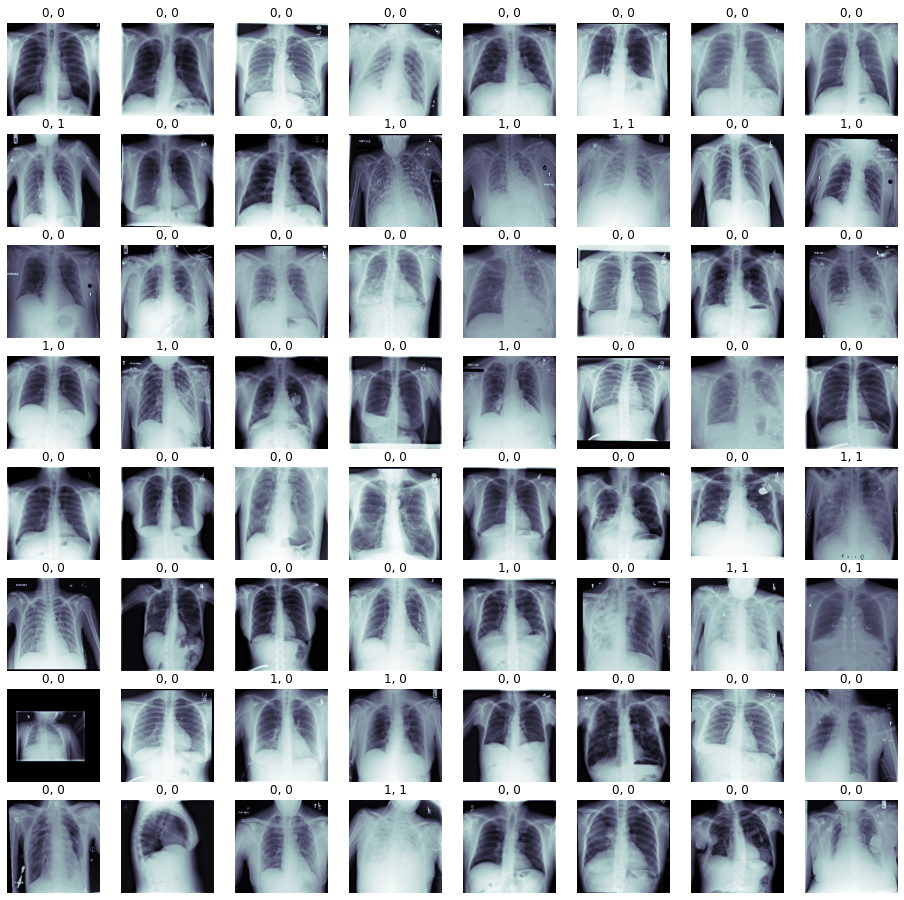

In [73]:
# Let's look at some examples of true vs. predicted with our best model: 

YOUR_THRESHOLD = best_threshold

fig, m_axs = plt.subplots(8, 8, figsize = (16, 16))
i = 0
for (c_x, c_y, c_ax) in zip(valX[0:64], valY[0:64], m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        if pred_Y[i] > YOUR_THRESHOLD:
            c_ax.set_title('1, 1')
        else:
            c_ax.set_title('1, 0')
    else:
        if pred_Y[i] > YOUR_THRESHOLD: 
            c_ax.set_title('0, 1')
        else:
            c_ax.set_title('0, 0')
    c_ax.axis('off')
    i=i+1

In [74]:
## Just save model architecture to a .json:

model_json = my_model.to_json()
with open("my_model.json", "w") as json_file:
    json_file.write(model_json)

In [75]:
my_model.save_weights("my_model_weights.h5")